# Problem 4: Noisy quantum gates
Part 3: Simulate the exact Fidelity $\mathcal{F}$ as a function of the ratio $J/\gamma$, and compare it to your analytical estimate.

In [1]:
# Importing relevant packages
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def create_H2(J): 
    #Creating a Hamiltonian H2 for two qubits. 
    '''Using the tensor function we can do this easily'''
    #Function qt.ket2dm takes in a ket |psi> and creates the density matrix associated with it |psi><psi|
    #Function qt.tensor(a,b) creates the tensor product between two kets or density matrices
    #Note that tensor only takes two arguments. For three arguments you need to call it twice: 
    # qt.tensor(a,qt.tensor(b,c))
    return J*qt.tensor(qt.ket2dm(qt.basis(2,1)), qt.ket2dm(qt.basis(2,1)))


def Evolve_H2_with_noise(psi, J, gamma, t, Ntimes=100): 
    """This function evolves the state psi under the H2 Hamiltonian with added dephasing of 
    stregth gamma for time t"""
    if gamma>1e-12:
        c_ops = [np.sqrt(gamma/2)*qt.tensor(qt.sigmaz(),qt.identity(dims=[2])),\
                 np.sqrt(gamma/2)*qt.tensor(qt.identity(dims=[2]),qt.sigmaz())]
        res = qt.mesolve(create_H2(J), psi, np.linspace(0,t, Ntimes), c_ops=c_ops)
    else: 
        res = qt.sesolve(create_H2(J), psi, np.linspace(0,t, Ntimes))
    return res.states

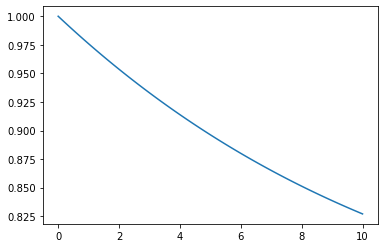

In [15]:
'''Testing our functions from above. We initialize in psi=|+>|1> '''
psi = qt.tensor((qt.basis(2, 0) + qt.basis(2, 1)).unit(), qt.basis(2,1))

t, J, gamma, Ntimes = 10, 1, 0.1, 100

states_with_noise = Evolve_H2_with_noise(psi, J, gamma, t, Ntimes=Ntimes)
states_no_noise = Evolve_H2_with_noise(psi, J, 0, t)

'''We measure the fidelity with the ideal states'''
fidelities = []
for i in range(Ntimes):
    fidelities.append(qt.metrics.fidelity(states_no_noise[i],states_with_noise[i]))
    
'''Plotting the fidelities'''
plt.figure()
plt.plot(np.linspace(0, t, Ntimes), fidelities)
#plt.plot(np.linspace(0, t, Ntimes), np.exp(-2 * gamma * np.linspace(0, t, Ntimes)))
plt.show()

In [21]:
'''Okay, now your turn! Here is what you need to do:
1. Define a new evolution function to account for your three qubit system (change H2 to H3, and 
account for 3 decay operators). 
2. Fix the total time based on what you found in other parts of the problem and get the fidelities
for different values of J/gamma'''
def create_H3(J): 
    #Creating a Hamiltonian H2 for two qubits. 
    '''Using the tensor function we can do this easily'''
    #Function qt.ket2dm takes in a ket |psi> and creates the density matrix associated with it |psi><psi|
    #Function qt.tensor(a,b) creates the tensor product between two kets or density matrices
    #Note that tensor only takes two arguments. For three arguments you need to call it twice: 
    # qt.tensor(a,qt.tensor(b,c))
    return J*qt.tensor(qt.ket2dm(qt.basis(2,1)), qt.ket2dm(qt.basis(2,1)), qt.ket2dm(qt.basis(2,1)))


def Evolve_H3_with_noise(psi, J, gamma, t, Ntimes=100): 
    """This function evolves the state psi under the H2 Hamiltonian with added dephasing of 
    stregth gamma for time t"""
    if gamma>1e-12:
        c_ops = [np.sqrt(gamma/2)*qt.tensor(qt.sigmaz(),qt.identity(dims=[2]), qt.identity(2)),\
                 np.sqrt(gamma/2)*qt.tensor(qt.identity(dims=[2]),qt.sigmaz(), qt.identity(2)),\
                 np.sqrt(gamma/2)*qt.tensor(qt.identity(2), qt.identity(2), qt.sigmaz())]
        res = qt.mesolve(create_H3(J), psi, np.linspace(0,t, Ntimes), c_ops=c_ops)
    else: 
        res = qt.sesolve(create_H3(J), psi, np.linspace(0,t, Ntimes))
    return res.states

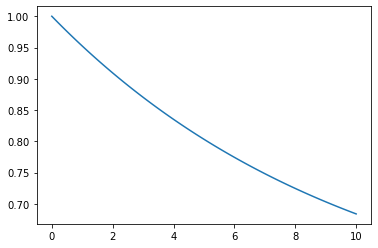

In [22]:
'''Testing our functions from above. We initialize in psi=|+>|+>|1> '''
psi = qt.tensor((qt.basis(2, 0) + qt.basis(2, 1)).unit(), (qt.basis(2,0) + qt.basis(2, 1)).unit(), qt.basis(2,1))

t, J, gamma, Ntimes = 10, 1, 0.1, 100

states_with_noise = Evolve_H3_with_noise(psi, J, gamma, t, Ntimes=Ntimes)
states_no_noise = Evolve_H3_with_noise(psi, J, 0, t)

'''We measure the fidelity with the ideal states'''
fidelities = []
for i in range(Ntimes):
    fidelities.append(qt.metrics.fidelity(states_no_noise[i],states_with_noise[i]))
    
'''Plotting the fidelities'''
plt.figure()
plt.plot(np.linspace(0, t, Ntimes), fidelities)
#plt.plot(np.linspace(0, t, Ntimes), np.exp(-2 * gamma * np.linspace(0, t, Ntimes)))
plt.show()

# Problem 5.3 
Now consider the implementation of Grover's algorithm with just one iteration, using imperfect CZ and $\mathrm{C^2Z}$ gates. Assume CZ and $\mathrm{C^2Z}$ gates are implemented as discussed in Problem 4, using $H_2$ and $H_3$ in Problem 4 respectively, subject to dephasing as in Problem 4 throughout the gate duration. Calculate the ratio $J/\gamma$ necessary to implement Grover's algorithm with an error probability $< 0.01$.

In [3]:
#You got this! You will have to break the evolution in steps. Let me give you some useful functions

'''Popular choices of gates can be found with in qutip.qip. Here is code to get single qubit gate'''
Hadamard = qt.qip.operations.snot()
X = 1j*qt.qip.operations.rx(np.pi)
Z = 1j*qt.qip.operations.rz(np.pi)

'''Here is a function that makes tensor products of an operator list'''
def make_op(ops, sites, N): 
    '''N=number of qubits, ops = [op1, op2,...], sites=[site of op1, site of op2,..]'''
    l = [qt.identity(dims=[2]) for i in range(N)]
    for i in range(len(sites)): l[sites[i]] = ops[i]
    m = l[0]
    for i in range(1,N): 
        m = qt.tensor(m, l[i])
    return m 

#Here is the operator H1X2Z3. Operator not relevant to the problem per-say but it illustrates 
#the function make_op
HXZ = make_op([Hadamard,X,Z], [0,1,2], 3)

#Here is the operator H1: 
HII = make_op([Hadamard], [0], 3)

#Recall that for an operator O12, a density matrix evolves as O12*rho*O12^\dagger. 
#For example, for the operator H1 on two qubits, using the two-qubit states we found above we have
O12 = make_op([Hadamard], [0], 2)
# O12*states_with_noise[-1]*O12

In [4]:
HXZ

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.          0.         -0.70710678  0.          0.
   0.         -0.70710678]
 [ 0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.         -0.70710678  0.          0.          0.         -0.70710678
   0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.
  -0.70710678  0.        ]
 [ 0.          0.          0.         -0.70710678  0.          0.
   0.          0.70710678]
 [ 0.70710678  0.          0.          0.         -0.70710678  0.
   0.          0.        ]
 [ 0.         -0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]]